In [1]:
import os

os.chdir('/home/yz979/code/kaggle-perturbation/')
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

train_path = 'data/de_train.parquet'
submit_path = 'data/id_map.parquet'

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
import networkx as nx

from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Union, Optional

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.norm import BatchNorm, GraphNorm
from torch.utils.data import Dataset, random_split

In [29]:
class TabularGraphDataset(Dataset):
    def __init__(self, df, cond_cols, target_cols, perturb_key, edge_index=None, edge_attr=None):
        self.df = df
        self.cond_cols = cond_cols
        self.perturb_key = perturb_key
        self.target_cols = target_cols
        self.cat_dict = {}
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.num_nodes = None

        for cond_col in cond_cols:
            unique_values = df[cond_col].unique()
            self.cat_dict[cond_col] = {val: i for i, val in enumerate(unique_values)}
        
        unique_values = df[perturb_key].unique()
        self.cat_dict[perturb_key] = {val: i for i, val in enumerate(unique_values)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        ret_dict = {}
        for cond_col in self.cond_cols:
            ret_dict[cond_col] = torch.tensor(self.cat_dict[cond_col][row[cond_col]])
        ret_dict[self.perturb_key] = torch.tensor(self.cat_dict[self.perturb_key][row[self.perturb_key]])
        target = torch.tensor(row[self.target_cols].values.astype(np.float32)) if self.target_cols else torch.tensor([0])
        return Data(x=None, edge_index=self.edge_index, edge_attr=self.edge_attr, num_nodes=self.num_nodes, **ret_dict), target

    def set_graph(self, edge_index, edge_attr):
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.num_nodes = edge_index.max().item() + 1

    def encode(self, val, col):
        return self.cat_dict[col][val]

    def decode(self, val, col):
        return list(self.cat_dict[col].keys())[val]

    def vocab_size(self, col):
        return len(self.cat_dict[col])

def validate_config(dataset, config):
    config['perturb_key'] = dataset.perturb_key
    for cond_col in dataset.cond_cols:
        config[f'num_{cond_col}s'] = dataset.vocab_size(cond_col)
    config[f'num_{dataset.perturb_key}s'] = dataset.vocab_size(dataset.perturb_key)
    config['num_targets'] = len(dataset.target_cols)
    config['conditions'] = dataset.cond_cols
    return config

def load_dataset(
    path,
    cond_cols = ['cell_type'],
    perturb_key = 'perturb',
    col_map = {'cell_type': 'cell_type', 'sm_lincs_id': 'perturb'},
    is_test = False,
    cat_dict = None,
):
    df = pd.read_parquet(path)
    df = df.rename(columns=col_map)
    target_cols = df.iloc[:, 5:].columns.tolist() if not is_test else None
    ds = TabularGraphDataset(df, cond_cols, target_cols, perturb_key)
    if cat_dict:
        ds.cat_dict = cat_dict
    return ds

@dataclass
class GeneSimNetwork():
    G: nx.DiGraph
    edge_index: torch.Tensor
    edge_weight: torch.Tensor
    
    @classmethod
    def from_edges(
        cls,
        edge_list: pd.DataFrame,
        gene_list: List,
        node_map: Dict[str, int],
        ) -> "GeneSimNetwork":
        """
        Generate gene similarity network from edge list

        Args:
            edge_list (pd.DataFrame): edge list of the network
            gene_list (list): list of gene names
            node_map (dict): dictionary mapping gene names to node indices

        Returns:
            GeneSimNetwork: gene similarity network
        """
        G = nx.from_pandas_edgelist(edge_list, source='source',
                                    target='target', edge_attr=['importance'],
                                    create_using=nx.DiGraph())
        for n in gene_list:
            if n not in G.nodes():
                G.add_node(n)

        to_remove = []
        for n in G.nodes():
            if n not in gene_list:
                to_remove.append(n)
        
        for n in to_remove:
            G.remove_node(n)

        edge_index_ = [(node_map[e[0]], node_map[e[1]]) for e in G.edges]

        edge_index = torch.tensor(edge_index_, dtype=torch.long).T
        
        edge_attr = nx.get_edge_attributes(G, 'importance') 
        importance = np.array([edge_attr[e] for e in G.edges])
        edge_weight = torch.Tensor(importance)
        
        return cls(G, edge_index, edge_weight)

def load_gene_network(path, gene_list, node_map):
    edge_list = pd.read_csv(path)
    return GeneSimNetwork.from_edges(edge_list, gene_list, node_map)

In [20]:
def mrrmse_loss(predicted, actual):
    squared_error = (predicted - actual) ** 2
    rowwise_mse = torch.mean(squared_error, dim=1)
    rowwise_rmse = torch.sqrt(rowwise_mse)
    mrrmse = torch.mean(rowwise_rmse)
    return mrrmse

def train_epoch(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0
    for i, (data, target) in enumerate(dataloader):
        data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(**data.to_dict())
        loss = mrrmse_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            data.to(device)
            target = target.to(device)
            output = model(**data.to_dict())
            loss = mrrmse_loss(output, target)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [34]:
class ConditionEncoder(nn.Module):
    def __init__(self, config, condition):
        super(ConditionEncoder, self).__init__()
        self.config = config
        self.condition = condition
        self.embeddings = nn.Embedding(self.config[f'num_{self.condition}s'], self.config['embed_size'])
        self.encoder = nn.Sequential(
            nn.Linear(self.config['embed_size'], self.config['hidden_size'] * 4),
            config['activation'],
            nn.Linear(self.config['hidden_size'] * 4, self.config['hidden_size'] // 2),
        )
        self.bn = nn.BatchNorm1d(self.config['hidden_size'] // 2) if self.config.get('batch_norm') else nn.Identity()

    def forward(self, x):
        return self.bn(self.encoder(self.embeddings(x)))

class PerturbationEncoder(nn.Module):
    def __init__(self, config, condition):
        super(PerturbationEncoder, self).__init__()
        raise NotImplementedError

class CellEncoder(nn.Module):
    perturb_encoder_cls = ConditionEncoder  # PerturbationEncoder is not implemented yet (TODO)

    def __init__(self, config):
        super(CellEncoder, self).__init__()
        self.config = config
        self.cell_embedding = nn.Parameter(torch.empty(1, self.config['num_targets'], self.config['embed_size']))  # replace with better embedding
        self.encoder = nn.Sequential(
            nn.Linear(self.config['embed_size'], self.config['hidden_size'] * 4),
            nn.Dropout(self.config['dropout']),
            config['activation'],
            nn.Linear(self.config['hidden_size'] * 4, self.config['hidden_size']),
        )
        for condition in self.config['conditions']:
            setattr(self, f'{condition}_encoder', ConditionEncoder(self.config, condition))
        self.perturb_encoder = self.perturb_encoder_cls(self.config, config['perturb_key'])
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.cell_embedding)

    def set_cell_embedding(self, cell_embedding):
        self.cell_embedding = nn.Parameter(cell_embedding, requires_grad=False)

    def forward(self, **kwargs):
        cell_embedding = self.cell_embedding
        condition_embedding = torch.cat([
            getattr(self, f'{condition}_encoder')(kwargs[condition]).unsqueeze(1)
            for condition in self.config['conditions']
            ], dim=1)
        condition_embedding = condition_embedding.sum(dim=1, keepdim=True)
        perturb_embedding = self.perturb_encoder(kwargs[self.config['perturb_key']]).unsqueeze(1)
        return self.encoder(cell_embedding) + torch.cat([condition_embedding, perturb_embedding], dim=2)

class ValueDecoder(nn.Module):
    def __init__(self, config):
        super(ValueDecoder, self).__init__()
        self.config = config
        self.decoder = nn.Sequential(
            nn.Linear(self.config['hidden_size'], self.config['hidden_size'] * 4),
            nn.Dropout(self.config['dropout']),
            config['activation'],
            nn.Linear(self.config['hidden_size'] * 4, 1),
        )

    def forward(self, x):
        return self.decoder(x).squeeze(-1)

class GCNLayer(nn.Module):
    def __init__(self, config):
        super(GCNLayer, self).__init__()
        self.config = config
        self.graph_conv = GCNConv(self.config['hidden_size'], self.config['hidden_size'])
        self.dropout = nn.Dropout(self.config['dropout'])
        self.act_fn = config['activation']
        
        self.ffn = nn.Sequential(
            nn.Linear(self.config['hidden_size'], self.config['hidden_size'] * 4),
            nn.Dropout(self.config['dropout']),
            config['activation'],
            nn.Linear(self.config['hidden_size'] * 4, self.config['hidden_size']),
        )
        self.batch_norm = GraphNorm(self.config['hidden_size']) if self.config.get('batch_norm') else nn.Identity()

    def forward(self, x, edge_index, edge_attr=None):
        x = self.act_fn(self.dropout(self.graph_conv(x, edge_index, edge_attr))) + x
        x = self.batch_norm(x)
        return x

class TransformerLayer(nn.Module):
    def __init__(self, config):
        super(TransformerLayer, self).__init__()
        self.config = config
        self.attn = nn.MultiheadAttention(self.config['hidden_size'], self.config['num_heads'])
        self.layer_norm_1 = nn.LayerNorm(self.config['hidden_size'])
        
        self.ffn = nn.Sequential(
            nn.Linear(self.config['hidden_size'], self.config['hidden_size'] * 4),
            nn.Dropout(self.config['dropout']),
            config['activation'],
            nn.Linear(self.config['hidden_size'] * 4, self.config['hidden_size']),
        )
        self.layer_norm_2 = nn.LayerNorm(self.config['hidden_size'])

    def forward(self, x):
        x = self.attn(x, x, x)[0] + x
        x = self.layer_norm_1(x)
        x = self.ffn(x) + x
        x = self.layer_norm_2(x)
        return x

class DERegressor(nn.Module):
    def __init__(self, config):
        super(DERegressor, self).__init__()
        self.config = config
        self.cell_encoder = CellEncoder(self.config)
        self.value_decoder = ValueDecoder(self.config)
        self.edge_index = None
        if self.config['model_type'] == 'gcn':
            self.gcn_layers = nn.ModuleList([GCNLayer(self.config) for _ in range(self.config['num_layers'])])
        elif self.config['model_type'] == 'transformer':
            self.transformer_layers = nn.ModuleList([TransformerLayer(self.config) for _ in range(self.config['num_layers'])])
    
    def forward(self, **kwargs):
        x = self.cell_encoder(**kwargs)
        edge_index = kwargs.pop('edge_index', None)
        if edge_index is None and self.edge_index is None:
            edge_index = torch.tensor([[i, j] for i in range(x.shape[1]) for j in range(x.shape[1]) if i != j], dtype=torch.long).t().to(x.device)
            self.edge_index = edge_index
        elif edge_index is None:
            edge_index = self.edge_index
        if self.config['model_type'] == 'gcn':
            for gcn_layer in self.gcn_layers:
                x = gcn_layer(x, edge_index)
        elif self.config['model_type'] == 'transformer':
            for transformer_layer in self.transformer_layers:
                x = transformer_layer(x)
        return self.value_decoder(x)

    def set_cell_embedding(self, cell_embedding):
        self.cell_encoder.set_cell_embedding(cell_embedding)

In [30]:
dataset = load_dataset(train_path)
submission = load_dataset(submit_path, is_test=True, cat_dict=dataset.cat_dict)

gene_list = dataset.df.columns[5:].tolist()
node_map = {gene: i for i, gene in enumerate(gene_list)}
gene_sim_network = load_gene_network('data/grn/go.csv', gene_list, node_map)

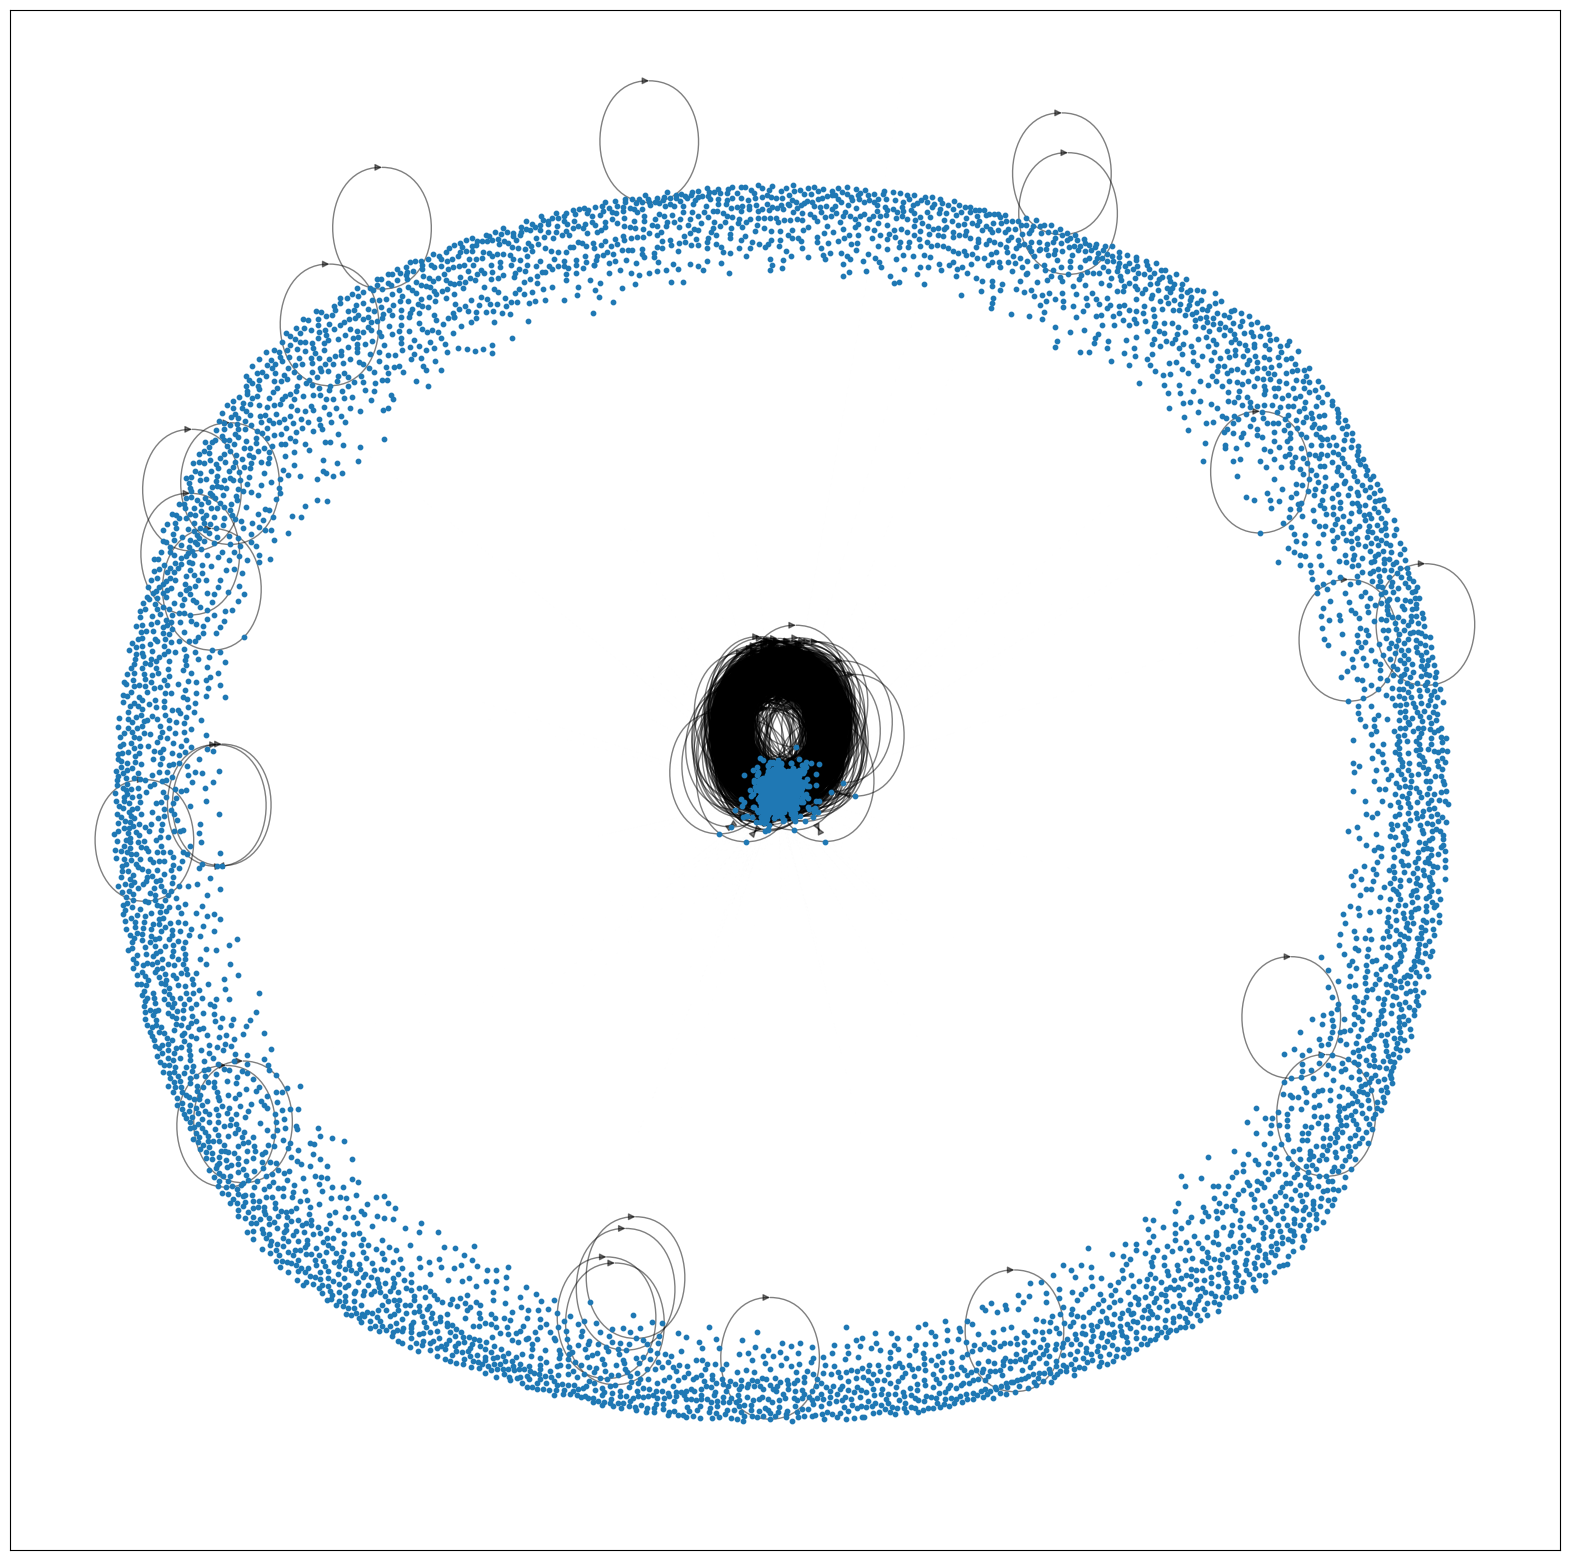

: 

In [39]:
# plot gene similarity network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(gene_sim_network.G)
nx.draw_networkx_nodes(gene_sim_network.G, pos, node_size=10)
nx.draw_networkx_edges(gene_sim_network.G, pos, alpha=0.5)
plt.show()

In [36]:
model_config = {
    'hidden_size': 64,
    'embed_size': 256,
    'activation': nn.LeakyReLU(),
    'num_layers': 4,
    'batch_norm': True,
    'dropout': 0.2,
    'model_type': 'grn',
}
model_config = validate_config(dataset, model_config)

dataset.set_graph(gene_sim_network.edge_index, gene_sim_network.edge_weight)

train_dataset, val_dataset = random_split(dataset, [int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(submission, batch_size=2, shuffle=False)

geneformer_embeddings = torch.load('models/geneformer_embeddings.pt')

In [38]:
model = DERegressor(model_config)
# model.set_cell_embedding(geneformer_embeddings)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

model = model.to(device)
for epoch in range(100):
    train_loss = train_epoch(model, optimizer, train_loader, device)
    val_loss = validate_epoch(model, val_loader, device)
    print(f'Epoch {epoch} train loss: {train_loss} val rmse: {val_loss}')
    scheduler.step()

Epoch 0 train loss: 1.326689662077488 val rmse: 1.3444468080997467
Epoch 1 train loss: 1.3034159204898736 val rmse: 1.3367687612771988
Epoch 2 train loss: 1.290679864394359 val rmse: 1.3265538662672043
Epoch 3 train loss: 1.2862036243463173 val rmse: 1.3258926272392273
Epoch 4 train loss: 1.2880498216702387 val rmse: 1.3212480992078781
Epoch 5 train loss: 1.2820762319442554 val rmse: 1.3190414756536484


KeyboardInterrupt: 

In [ ]:
# submit
model.eval()
preds = []
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
        data.to(device)
        output = model(**data.to_dict())
        preds.append(output.cpu().numpy())

IndexError: index 0 is out of bounds for dimension 0 with size 0